# How to model present bias or the impatient Robinson

Up to now, we have implicitely assumed Robinson to be forward-looking with respect to his intertemporal preferences, such that he maximizes the expected present value of utility over the remaining lifetime according to

$$
    U_t(u_t, u_{t+1}, ...) \equiv \sum^{T}_{t=0}
            {\delta^{t}u_t}
$$

where $\delta \in (0,1]$ is the usual standard discount factor representing time-consistent preferences. With ``respy`` you can solve a discrete choice dynamic programming model for a (completely naïve) agent with time-inconsistent preferences just as easily. 

We represent time-inconsistency with the popular formulation by O’Donoghue and Rabin (1999): ($\beta$-$\delta$) preferences, defined as


$$
    U_t(u_t, u_{t+1}, ...) \equiv u_t + \beta \sum^{T}_{k=t+1}
            {\delta^{k-t}u_k}
$$

where $\beta \in (0, 1]$ is the present-bias factor that captures time-inconsistent discounting, or impatience; the tendency to prefer activities that are immediately rewarded while procrastinating those that require an immediate cost. If $\beta = 1$ we are back to the time-consistent case.

In this tutorial, we will see how to model the behavior of an impatient Robinson who is additionally completely naïve with respect to his own time preferences, that is, at each point in time believes he will act time-consistently in future periods.

In [1]:
%matplotlib agg

import io
import matplotlib.pyplot as plt
import pandas as pd
import respy as rp
import numpy as np

## Specifications

To represent Robinson's impatience, we just need to add ``"beta"`` to the string containing the parameters and specifications of the model. ``"beta"`` is by default equal to 1 (time-consistent discounting). Here we set it to 0.4:

In [2]:
params_beta = """
category,name,value
beta,beta, 0.4
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_fishing,constant,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
lagged_choice_1_hammock,constant,1
"""

In [3]:
params_beta = pd.read_csv(io.StringIO(params_beta), index_col=["category", "name"])
params_beta

value
category                name                          
beta                    beta                      0.40
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

In this tutorial, we will compare the behavior of:

1. A time-consistent Robinson (``"beta"``= 1)
2. An impatient Robinson (``"beta"`` = 0.4)
3. A very impatient Robinson (``"beta"`` = 0.05)

Therefore, we will need two additional sets of ``params``.

In [4]:
# Set of parameters for time-consistent Robinson (as beta is read by default as 1)
params = params_beta.drop(labels="beta", level="category")

# Set of parameters for very impatient Robinson
params_lowbeta = params_beta.copy()
params_lowbeta.loc[("beta", "beta"), "value"] = 0.05

... while the ``options`` specifications do not change:

In [5]:
_, options = rp.get_example_model("robinson_crusoe_basic", with_data=False)

## Simulation 

### Basic Model

We start by simulating the basic model for our three Robinsons.

In [6]:
# Simulation for time-consistent Robinson
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

In [7]:
# Simulation for impatient Robinson
simulate = rp.get_simulate_func(params_beta, options)
df_beta = simulate(params_beta)

In [8]:
# Simulation for very impatient Robinson
simulate = rp.get_simulate_func(params_lowbeta, options)
df_lowbeta = simulate(params_lowbeta)

We can then compare their decisions period by period. The grouped stacked bar chart below and all the other visualizations can be easily generated with the ``Matplotlib`` library.

In [9]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()

x = np.arange(10)

bar_width = 0.25

colors = [["#1f77b4", "#ff7f0e"], ["#428dc1", "#ff9833"], ["#70a8d0", "#ffb369"]]
labels = ["β=1", "β=0.4", "β=0.05"]
positions = [x, x+bar_width*1.2, x+bar_width*2.4]

for i, series in enumerate([df, df_beta, df_lowbeta]):
    hammock = series.groupby("Period").Choice.value_counts().unstack().loc[:, "hammock"]
    fishing = series.groupby("Period").Choice.value_counts().unstack().loc[:, "fishing"]
    ax.bar(positions[i], fishing, width=bar_width, color=colors[i][0], label=labels[i])
    ax.bar(positions[i], hammock, width=bar_width, bottom=fishing, color=colors[i][1], label=labels[i])
    
ax.set_xticks(x + 2*bar_width / 2)
ax.set_xticklabels(np.arange(10))
ax.set_xlabel("Periods")

handles, _ = ax.get_legend_handles_labels()
handles_positions = [[0, 2, 4], [1, 3, 5]] 
bbox_to_anchor=[(1.12, 0.5), (1.12, 0.8)]

for i, title in enumerate(["fishing", "hammock"]):
    legend = plt.legend(handles=list(handles[j] for j in handles_positions[i]), 
    ncol=1, bbox_to_anchor=bbox_to_anchor[i], title=title, frameon=False)
    plt.gca().add_artist(legend)

fig.suptitle("Robinson's choices", y = 0.95);    

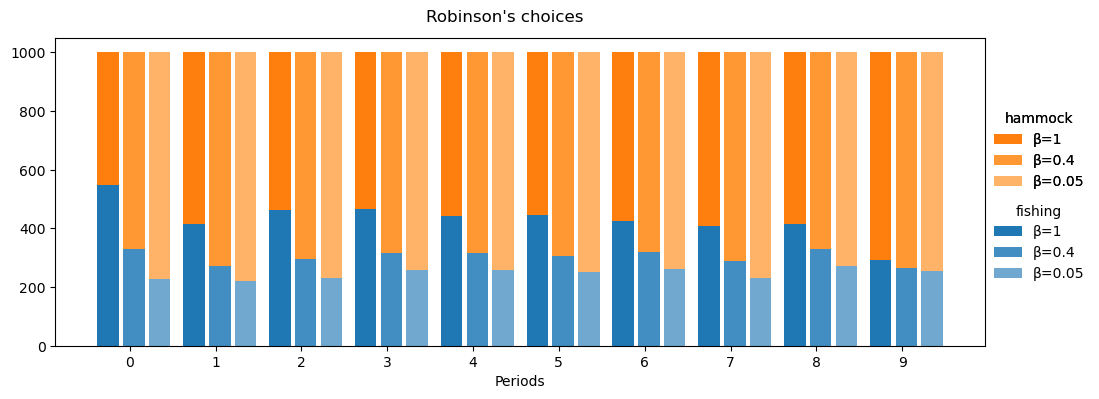

In [10]:
fig

We can see that the impatient Robinsons is less likely to go fishing than the time-consistent Robinson in each period, but even a very impatient Robinson will spend at least two periods fishing.

We can also compare the behavior of the Robinsons for different returns to experience. 

In [11]:
# Specification of grid for evaluation
n_points = 15    
grid_start = 0
grid_stop = 0.3

grid_points = np.linspace(grid_start, grid_stop, n_points)

mean_max_exp_fishing_by_beta = []
for p in [params, params_beta, params_lowbeta]:
    mean_max_exp_fishing = []
    for value in grid_points:
        p.loc["wage_fishing", "exp_fishing"] = value
        df = simulate(p)
        stat = df.groupby("Identifier")["Experience_Fishing"].max().mean()
        mean_max_exp_fishing.append(stat)
    mean_max_exp_fishing_by_beta.append(mean_max_exp_fishing)

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
labels = ["β=1", "β=0.4", "β=0.05"]

for mean_max_exp_fishing, label in zip(mean_max_exp_fishing_by_beta, labels):
    plt.plot(grid_points, mean_max_exp_fishing, label=label)

plt.ylim([0, 10])
plt.xlabel("Return to experience")
plt.ylabel("Average final level of experience")

plt.legend();

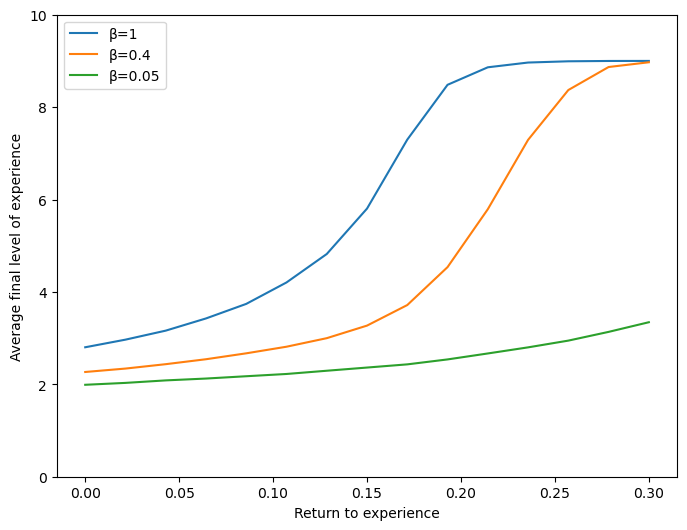

In [13]:
fig

For the same return to experience, time-inconsistent Robinsons attain lower average level of final experience, with the behavior of the very impatient Robinson obviously being the least reactive to an increasing return of experience.

We've seen that an impatient agent heavily discounts the stream of utility from future periods. A completely myopic agent, whose preferences are represented by a ``"delta"`` equal to 0, does not put any weight on his future utility. We may wonder whether having a very degree of impatience, represented by a very low ``"beta"``, may be equivalent to being completely myopic.

In [14]:
# Set of parameters for myopic Robinson
params_myopic = params.copy()
params_myopic.loc[("delta", "delta"), "value"] = 0

In [15]:
# Simulation for myopic Robinson
simulate = rp.get_simulate_func(params_myopic, options)
df_myopic = simulate(params_myopic)

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df_myopic.groupby("Period").Choice.value_counts().unstack().plot.bar(
    ax=axs[0], stacked=True, rot=0, legend=False, title="Completely myiopic")
df_lowbeta.groupby("Period").Choice.value_counts().unstack().plot.bar(
    ax=axs[1], stacked=True, rot=0, title="With present bias (β=0.05)")

handles, _ = axs[0].get_legend_handles_labels()
axs[1].get_legend().remove()
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3)
fig.suptitle("Robinson's choices", fontsize=14, y=1.05)

plt.tight_layout(rect=[0,0.05,1,1])

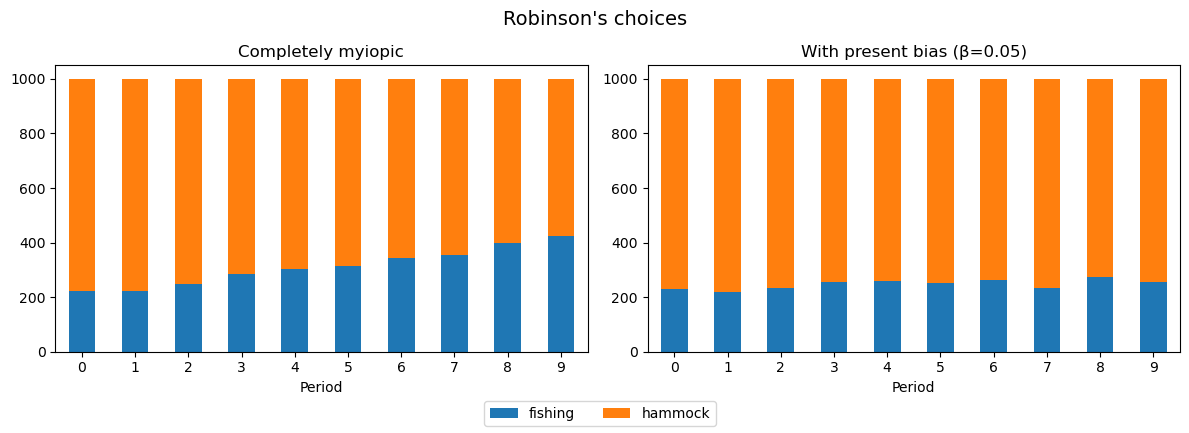

In [17]:
fig

We can see that the behavior of the two Robinsons differ. What comes into play is the _naïveté_ of the time-inconsistent Robinson: remember that at each point in time he (falsely) believes he will act time-consistently in future period. The result is that Robinson keeps procrastinating the fishing task, without ever acting time-consistently nor learning his true preferences.

### Extended Model 

Let's see what happens in the extended model. Remember that the extended model includes the additional covariate ``"contemplation_with_friday"``, a choice available once, starting from the third period, and only if Robinson has been fishing before. Remember that choosing to interact with Friday enters Robinson's utility negatively, reflecting the effort costs of learning and the food penalty.

This time we compare the behavior of a time-consistent Robinson with that of a time-inconsistent Robinson with ``"beta"`` = 0.4.
First, we load the model's options and parameters:

In [18]:
params_ext, options_ext = rp.get_example_model("robinson_crusoe_extended", with_data=False)

Then, we create another set of parameters for impatient Robinson, which differs from the previous one only in the value of ``"beta"``:

In [19]:
index = pd.MultiIndex.from_tuples([("beta", "beta")], names=["category", "name"])
beta = pd.DataFrame(0.4, index=index, columns=["value"])
params_beta_ext = beta.append(params_ext)

Again, we simulate the model for time-consistent and for impatient Robinson:

In [20]:
simulate = rp.get_simulate_func(params_ext, options_ext)
df_ext = simulate(params_ext)

In [21]:
simulate = rp.get_simulate_func(params_beta_ext, options_ext)
df_beta_ext = simulate(params_beta_ext)

We are now ready to compare Robinsons' choices period by period.

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df_ext.groupby("Period").Choice.value_counts().unstack().plot.bar(
    ax=axs[0], stacked=True, rot=0, legend=False, title="Without present bias", color=["C0", "C2", "C1"])
df_beta_ext.groupby("Period").Choice.value_counts().unstack().plot.bar(
    ax=axs[1], stacked=True, rot=0, title="With present bias (β=0.4)", color=["C0", "C2", "C1"])

handles, _ = axs[0].get_legend_handles_labels()
axs[1].get_legend().remove()
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3)
fig.suptitle("Robinson's choices", fontsize=14, y=1.05)

plt.tight_layout(rect=[0,0.05,1,1])

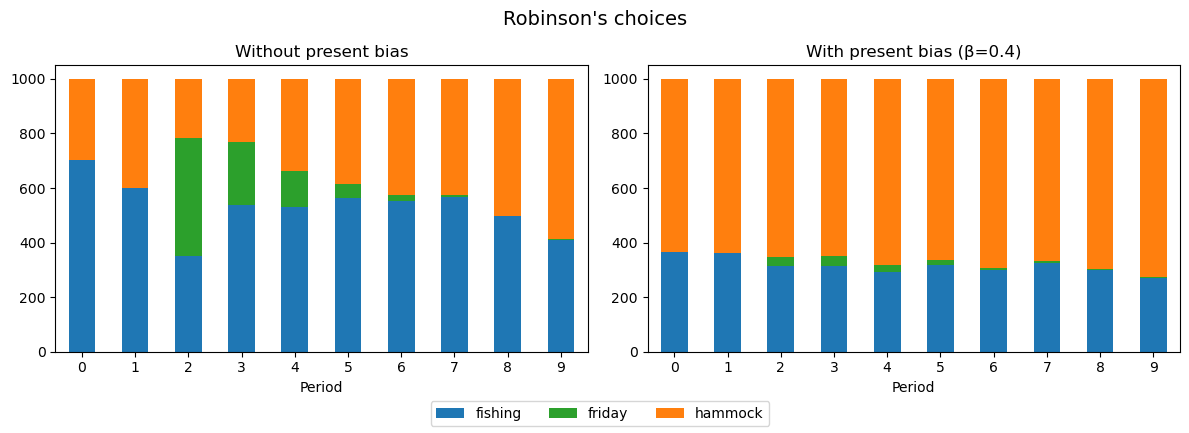

In [23]:
fig

Unsurprisingly, a Robinson who's a completely naïve, time-incosistent discounter is unlikely to interact with Friday, who would teach him how to fish but affect Robinson's utility negatively in that period. 

## References

> O'Donoghue, T. and and Rabin, M. (1999). [Doing It Now or Later](https://doi.org/10.1257/aer.89.1.103). *American Economic Review*, 89(1): 103-124.